In [1]:
# Libraries
import numpy as np
import pandas as pd
import gym
from tqdm import tqdm

import sys
sys.path.append('../')

# RL Agents
from agents.monte_carlo_exploring_starts_agent import MonteCarloExploringStartsAgent
from agents.q_learning_agent import QLearningAgent

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.tri import Triangulation
import seaborn as sns

sns.set_context("talk")
plt.rcParams["figure.figsize"] = (12, 8)

# Frozen Lake Funtions
Auxiliary functions for the frozen lake environment.

In [2]:
def plot_frozen_lake(df_summary):

    # Label dict
    direction_dict = {0:"←", 1:"↓", 2:"→", 3:"↑"}
    terminal_states = [5, 7, 11, 12, 15] 
    
    df_temp = df_summary.copy()

    df_temp["label"] = df_temp["optimal_action"].apply(lambda x: direction_dict[x])
    df_temp["x"] = df_temp["state"].apply(lambda x: x//4)
    df_temp["y"] = df_temp["state"].apply(lambda x: x%4)

    df_temp = df_temp[~df_temp["state"].isin(terminal_states)]

    # Reshape Data
    returns = df_temp.pivot("x", "y", "state_value")
    direction = df_temp.pivot("x", "y", "label")

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16,7))
    fig.suptitle('State Values for Optimal Policy')

    sns.heatmap(returns, annot=True, linewidths=.5, cbar=False, cmap="Blues", ax=axes[0])
    sns.heatmap(returns, annot=np.array(direction), linewidths=.5, cbar=False, cmap="Blues", fmt = '', ax=axes[1])

In [3]:
def triangulation_for_triheatmap(M, N):
    xv, yv = np.meshgrid(np.arange(-0.5, M), np.arange(-0.5, N))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, M), np.arange(0, N))  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (M + 1) * (N + 1)  # indices of the centers

    trianglesN = [(i + j * (M + 1), i + 1 + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesE = [(i + 1 + j * (M + 1), i + 1 + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesS = [(i + 1 + (j + 1) * (M + 1), i + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesW = [(i + (j + 1) * (M + 1), i + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    return [Triangulation(x, y, triangles) for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]]

def plot_state_action_frozen_lake(df_summary):

    direction_dict = {0:"←", 1:"↓", 2:"→", 3:"↑"}
    terminal_states = [5, 7, 11, 12, 15] 

    df_temp = df_summary.copy()

    df_temp["label"] = df_temp["optimal_action"].apply(lambda x: direction_dict[x])
    df_temp["x"] = df_temp["state"].apply(lambda x: x//4)
    df_temp["y"] = df_temp["state"].apply(lambda x: x%4)

    df_temp = df_temp[~df_temp["state"].isin(terminal_states)]
    df_temp = df_temp[["x","y",0,1,2,3]]

    df_piv = df_temp.pivot_table(index='x', columns='y')

    M = len(df_piv.columns) // 4
    N = len(df_piv)
    values = [df_piv[dir] for dir in
            [3, 2, 1, 0]]  # {0: '←', 1: '↓', 2: '→', 3: '↑'}

    triangul = triangulation_for_triheatmap(M, N)
    cmaps = ['Blues'] * 4

    norms = [plt.Normalize(0, 1) for _ in range(4)]
    fig, ax = plt.subplots(figsize=(16, 7))
    imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm, ec='white')
            for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]


    for val, dir in zip(values, [(-1, 0), (0, 1), (1, 0), (0, -1)]):
        for i in range(M):
            for j in range(N):
                v = val[i][j]
                ax.text(i + 0.3 * dir[1], j + 0.3 * dir[0], f'{v:.2f}', color='k' if 0.2 < v < 0.8 else 'w', ha='center', va='center')

    ax.tick_params(length=0)
    ax.set_xticks(range(M))
    ax.set_xticklabels(df_piv[3].columns)
    ax.set_yticks(range(N))
    ax.set_yticklabels(df_piv.index)
    ax.invert_yaxis()
    ax.margins(x=0, y=0)

    ax.set_title("State-Action Values")

    plt.tight_layout()
    plt.show()

# Environment Setup

In [4]:
# Environment
env = gym.make("FrozenLake-v1")

# Number of runs and episodes per run
num_runs = 250
num_episodes = 500

## Monte Carlo Exploring Starts Agent

In [5]:
# Parameters
gamma = 1
terminal_states = [5, 7, 11, 12, 15]

# Agent information
agent_info = {"num_actions": env.action_space.n, 
              "num_states": env.observation_space.n, 
              "gamma": gamma}

# Record num steps and rewards 
all_num_steps = []
all_rewards = []

# Summary table for each run
all_q = []

# Iterate
for _ in tqdm(range(num_runs)):
    
    # Initialize Agent
    agent = MonteCarloExploringStartsAgent(agent_info)

    num_steps = 0
    total_reward = 0

    cache_num_steps = []
    cache_rewards = []

    for _ in range(num_episodes):

        # Reset env
        env.reset()

        # Select a random start
        state = env.observation_space.sample()
        while state in terminal_states: # Fix if starting state is terminal
            state = env.observation_space.sample()

        # Change initial state
        env = env.unwrapped
        env.s = state

        # Initial action
        action = agent.agent_start(state)
        done = False

        episode_len = 0

        while not done:

            episode_len += 1
            if episode_len > 1000:
                done = True
                break

            new_state, reward, done, _ = env.step(action)
            new_action = agent.agent_step(reward, new_state)

            # Update values
            num_steps += 1
            total_reward += reward

            cache_num_steps.append(num_steps)
            cache_rewards.append(total_reward)

            # Update state and action
            state, action = new_state, new_action

        agent.agent_end(reward)

    # Append summary table
    all_q.append(agent.create_summary_table())

    # Add rewards and steps
    all_num_steps.append(cache_num_steps)
    all_rewards.append(cache_rewards)

100%|██████████| 250/250 [00:43<00:00,  5.79it/s]


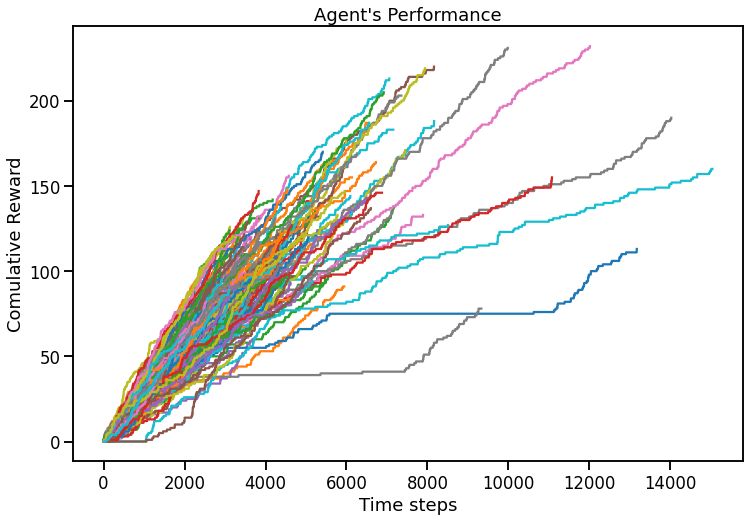

In [6]:
# All plots
for steps, rewards in zip(all_num_steps, all_rewards):
    plt.plot(steps, rewards)

plt.title("Agent's Performance")
plt.xlabel("Time steps")
plt.ylabel("Comulative Reward")

plt.show()

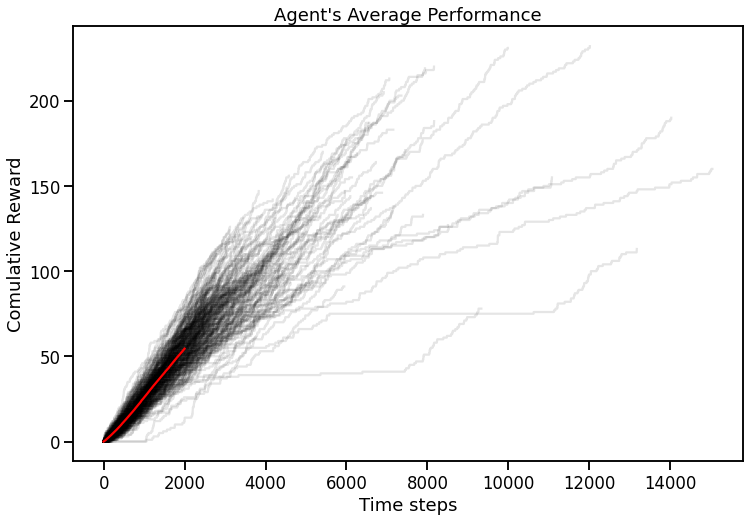

In [7]:
# Average Plot
for steps, rewards in zip(all_num_steps, all_rewards):
    plt.plot(steps, rewards, alpha=0.1, color="black")

min_len = min([len(l) for l in all_num_steps])
truncated_all_rewards = [a[:min_len] for a in all_rewards]

plt.plot(np.arange(min_len), np.array(truncated_all_rewards).mean(axis=0), color='red')
    
plt.title("Agent's Average Performance")
plt.xlabel("Time steps")
plt.ylabel("Comulative Reward")

plt.show()

In [61]:
# 
total_sum = (all_q[0]).iloc[:,1:5]
for i in range(1,len(all_q)):
    total_sum += (all_q[i]).iloc[:,1:5]

state_actions = total_sum/len(all_q)
state_actions["optimal_action"] = np.array(state_actions).argmax(axis=1)
state_actions["state_value"] = np.max(state_actions.iloc[:,:4], axis=1)
state_actions["state"] = state_actions.index

mc_policy = dict(zip(state_actions.index, state_actions.optimal_action))
mc_policy

{0: 0,
 1: 3,
 2: 0,
 3: 3,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 3,
 9: 1,
 10: 0,
 11: 0,
 12: 0,
 13: 2,
 14: 1,
 15: 0}

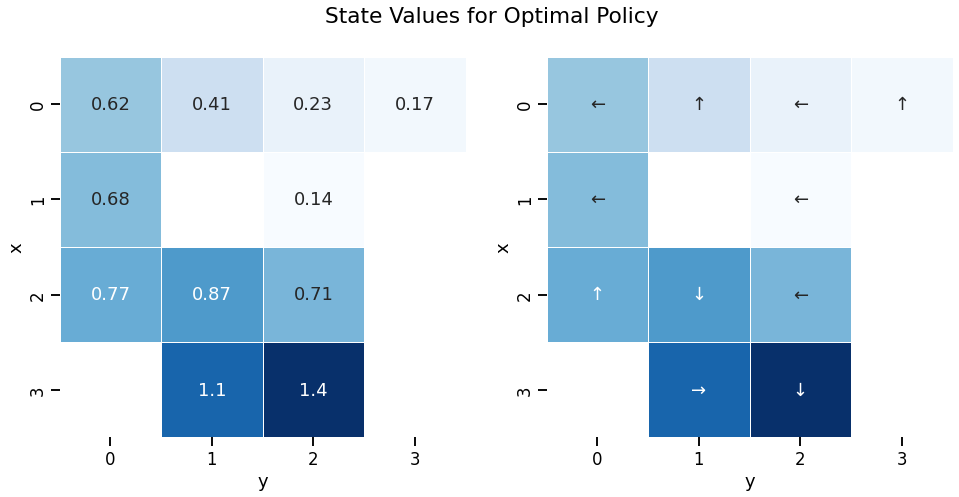

In [63]:
# State values plot
plot_frozen_lake(state_actions)

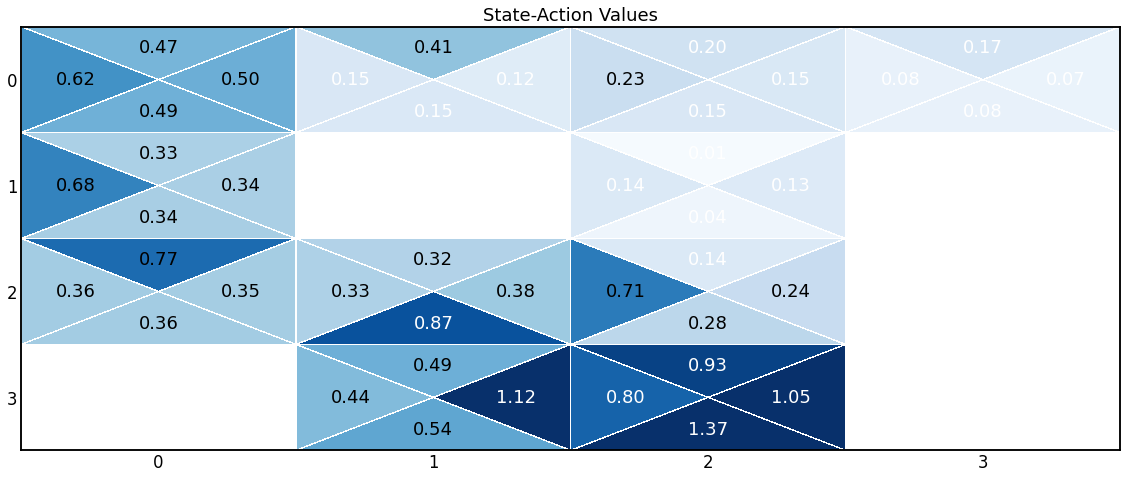

In [64]:
# State-Action values
plot_state_action_frozen_lake(state_actions)

## Q-Learning Agent

In [11]:
# Parameters
epsilon = 0.05
alpha = 0.5
gamma = 0.98

# Agent information
agent_info = {"num_actions": env.action_space.n, 
              "num_states": env.observation_space.n, 
              "epsilon": epsilon, 
              "alpha": alpha, 
              "gamma": gamma}

# Record num steps and rewards 
all_num_steps = []
all_rewards = []

# Summary table for each run
all_q = []

# Iterate
for _ in tqdm(range(num_runs)):
    
    # Initialize Agent
    agent = QLearningAgent(agent_info)

    num_steps = 0
    total_reward = 0

    cache_num_steps = []
    cache_rewards = []

    for _ in range(num_episodes):

        # Reset env
        env.reset()
        state = env.s

        # Initial action
        action = agent.agent_start(state)
        done = False

        while not done:

            new_state, reward, done, _ = env.step(action)
            new_action = agent.agent_step(reward, new_state)

            # Update values
            num_steps += 1
            total_reward += reward

            cache_num_steps.append(num_steps)
            cache_rewards.append(total_reward)

            # Update state and action
            state, action = new_state, new_action

        agent.agent_end(reward)

    # Append summary table
    all_q.append(agent.create_summary_table())

    # Add rewards and steps
    all_num_steps.append(cache_num_steps)
    all_rewards.append(cache_rewards)

100%|██████████| 250/250 [01:30<00:00,  2.75it/s]


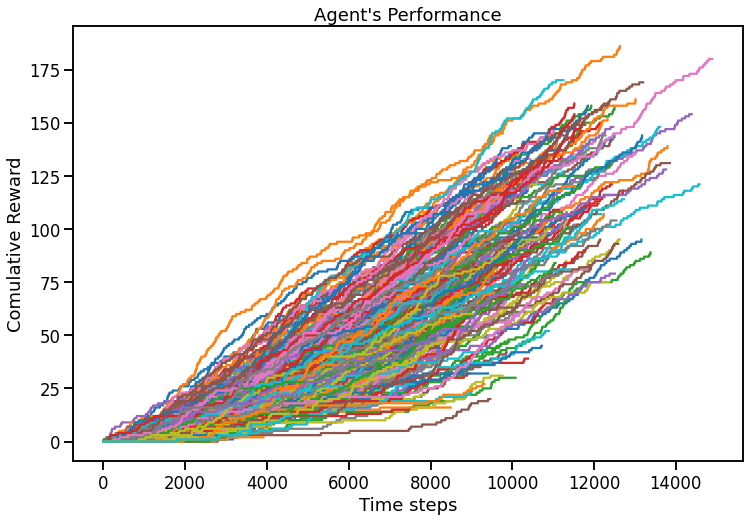

In [12]:
# All plots
for steps, rewards in zip(all_num_steps, all_rewards):
    plt.plot(steps, rewards)

plt.title("Agent's Performance")
plt.xlabel("Time steps")
plt.ylabel("Comulative Reward")

plt.show()

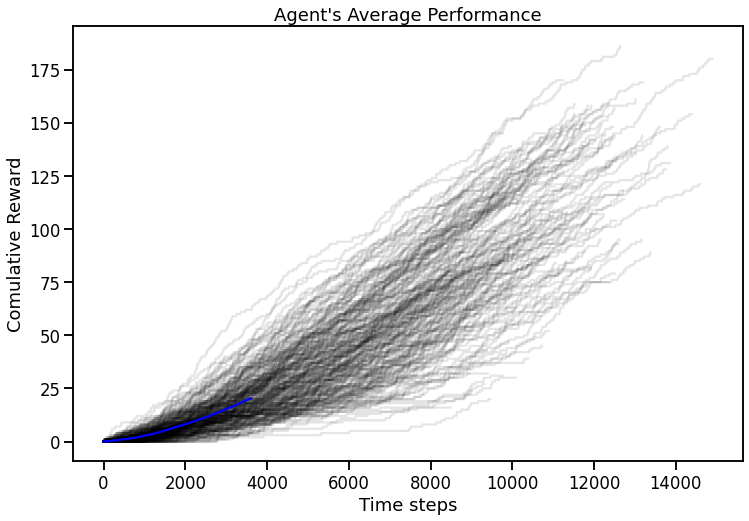

In [13]:
# Average Plot
for steps, rewards in zip(all_num_steps, all_rewards):
    plt.plot(steps, rewards, alpha=0.1, color="black")

min_len = min([len(l) for l in all_num_steps])
truncated_all_rewards = [a[:min_len] for a in all_rewards]

plt.plot(np.arange(min_len), np.array(truncated_all_rewards).mean(axis=0), color='blue')
    
plt.title("Agent's Average Performance")
plt.xlabel("Time steps")
plt.ylabel("Comulative Reward")

plt.show()

In [14]:
# Get the most popular policy
popular_policies = {}

for q in all_q:

    policy = tuple(q["optimal_action"])

    if policy not in popular_policies:
        popular_policies[policy] = 1
    else:
        popular_policies[policy] += 1


# Sorted by vpopularity
sorted_policies = {k: v for k, v in sorted(popular_policies.items(), key=lambda item: item[1])}
sorted_policies


{(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 2, 0, 0, 1, 2, 1): 1,
 (0, 0, 2, 0, 0, 0, 0, 0, 3, 1, 1, 0, 0, 2, 1, 1): 1,
 (0, 1, 3, 3, 0, 0, 2, 0, 1, 1, 1, 0, 0, 3, 2, 1): 1,
 (0, 3, 1, 3, 0, 0, 2, 0, 3, 1, 2, 0, 0, 2, 1, 0): 1,
 (0, 0, 2, 3, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 3, 3): 1,
 (0, 3, 1, 0, 0, 0, 3, 0, 3, 1, 1, 0, 0, 2, 3, 1): 1,
 (0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 1, 0, 0, 2, 1, 3): 1,
 (0, 3, 3, 3, 0, 0, 3, 0, 3, 1, 1, 0, 0, 2, 1, 3): 1,
 (0, 0, 0, 3, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 2): 1,
 (0, 3, 0, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 2, 3, 1): 1,
 (0, 0, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 3): 1,
 (2, 3, 3, 3, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1, 0): 1,
 (0, 1, 2, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 3, 2, 2): 1,
 (1, 3, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 2): 1,
 (0, 3, 3, 3, 0, 0, 1, 0, 3, 2, 0, 0, 0, 3, 1, 1): 1,
 (3, 3, 0, 3, 0, 0, 2, 0, 1, 1, 0, 0, 0, 1, 2, 2): 1,
 (1, 3, 2, 3, 0, 0, 0, 0, 3, 3, 2, 0, 0, 1, 2, 0): 1,
 (0, 3, 0, 3, 2, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0): 1,
 (0, 2, 0, 0, 0, 0, 0, 0, 3,

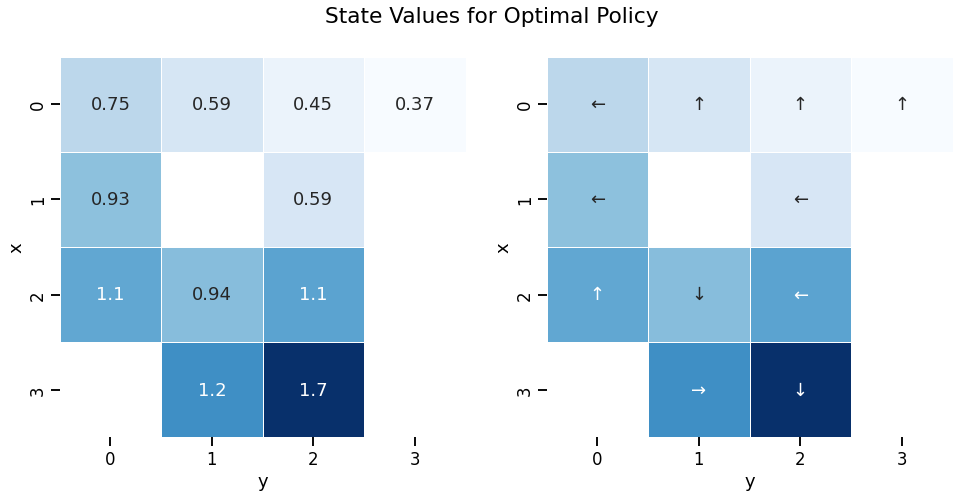

In [15]:
# State values plot
for i in range(num_runs):
    plot_frozen_lake(all_q[i])
    break

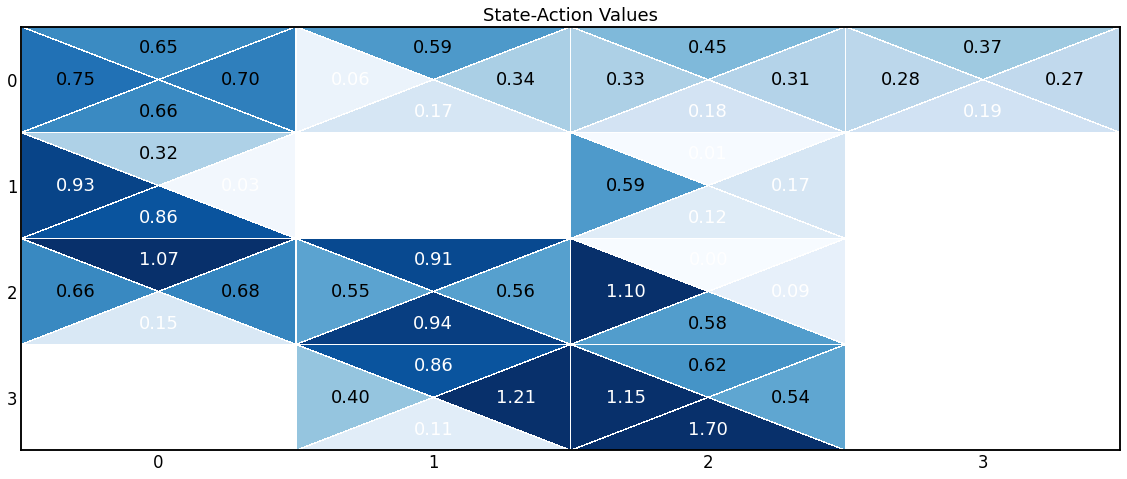

In [16]:
# State-Action values
for i in range(num_runs):
    plot_state_action_frozen_lake(all_q[i])
    break

## Testing

Test one game using a deterministic policy.

In [65]:
# Set a deterministic policy
#policy = {0:0, 1:3, 2:3, 3:3, 4:0, 5:0, 6:0, 7:0, 8:3, 9:1, 10:0, 11:0, 12:0, 13:2, 14:1, 15:0}

# Most popular policy
policy_vals = list(sorted_policies.keys())[-1]
policy = dict(zip(np.arange(len(policy_vals)), policy_vals))

# MC
policy = mc_policy

policy

{0: 0,
 1: 3,
 2: 0,
 3: 3,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 3,
 9: 1,
 10: 0,
 11: 0,
 12: 0,
 13: 2,
 14: 1,
 15: 0}

In [66]:
# Reset env
env.reset()
env.render()
state = env.s

# Initial action
action = policy[state]
done = False

while not done:

    new_state, reward, done, _ = env.step(action)
    new_action = policy[new_state]

    # Render
    env.render()

    # Update state and action
    state, action = new_state, new_action

Test the percentage of winning games, for n=100,000 games.

In [67]:
# Set number of games
num_games = 100000

cum_reward = 0

for _ in tqdm(range(num_games)):

    # Reset env
    env.reset()
    state = env.s

    # Initial action
    action = policy[state]
    done = False

    while not done:

        new_state, reward, done, _ = env.step(action)
        new_action = policy[new_state]

        # Update reward
        cum_reward += reward

        # Update state and action
        state, action = new_state, new_action

print("Percentage of successful games: {:.2f}%".format(100*cum_reward/num_games))

100%|██████████| 100000/100000 [00:35<00:00, 2845.19it/s]

Percentage of successful games: 78.03%


Plot and save a sample game

In [23]:
def save_env(img_num):
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')
    #plt.savefig(f'demo_images/image{img_num}.png', bbox_inches='tight')


Currently on step: 1
Currently on step: 2
Currently on step: 3
Currently on step: 4
Currently on step: 5
Currently on step: 6
Currently on step: 7
Currently on step: 8
Currently on step: 9
Currently on step: 10
Currently on step: 11
Currently on step: 12
Currently on step: 13
Currently on step: 14
Currently on step: 15
Currently on step: 16
Currently on step: 17


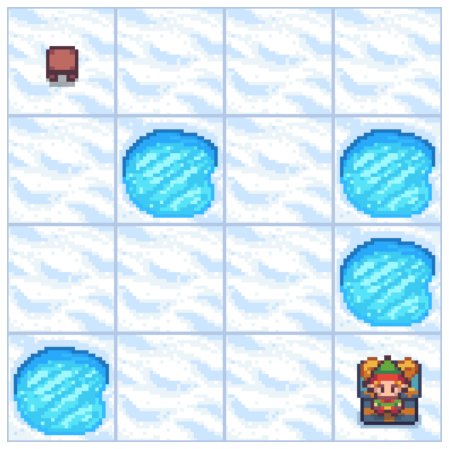

In [24]:
# Environment
env = gym.make("FrozenLake-v1")
img_num = 0

# Reset env
env.reset()
env.render()
save_env(img_num)
state = env.s

# Initial action
action = policy[state]
done = False

# History
all_states = [state]
all_actions = [action]

while not done:

    img_num += 1
    
    new_state, reward, done, _ = env.step(action)
    new_action = policy[new_state]

    # Update values
    all_states.append(new_state)
    all_actions.append(new_action)

    # Render
    env.render()
    save_env(img_num)
    print(f"Currently on step: {img_num}")

    # Update state and action
    state, action = new_state, new_action

In [25]:
print("States: ", all_states)
print("Actions: ", all_actions)

States:  [0, 0, 4, 4, 4, 4, 8, 8, 8, 8, 9, 13, 14, 13, 14, 13, 14, 15]
Actions:  [0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 1, 2, 1, 2, 1, 2, 1, 0]


Read images from file and create ppt template

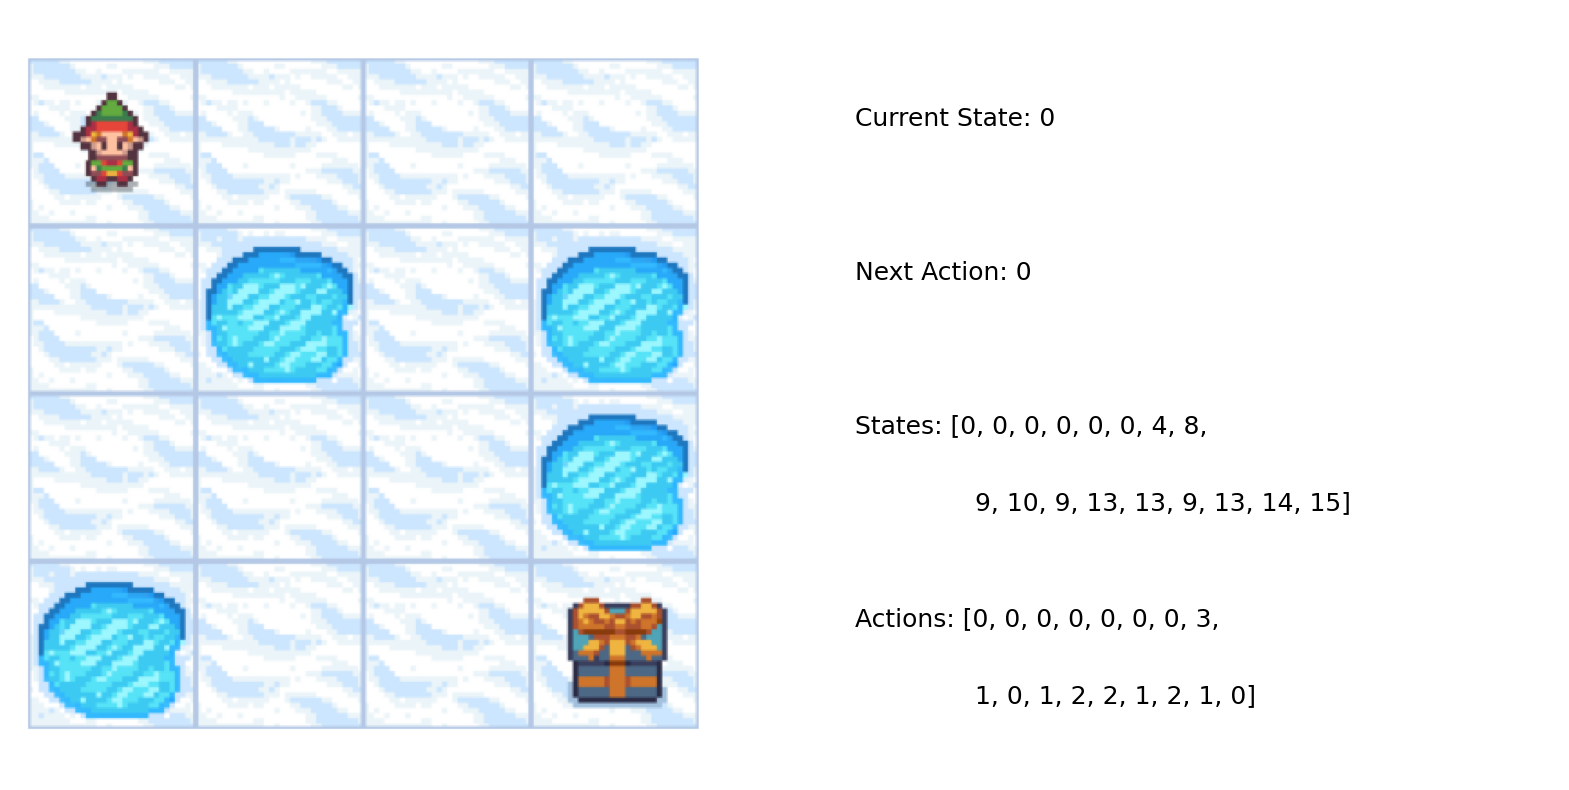

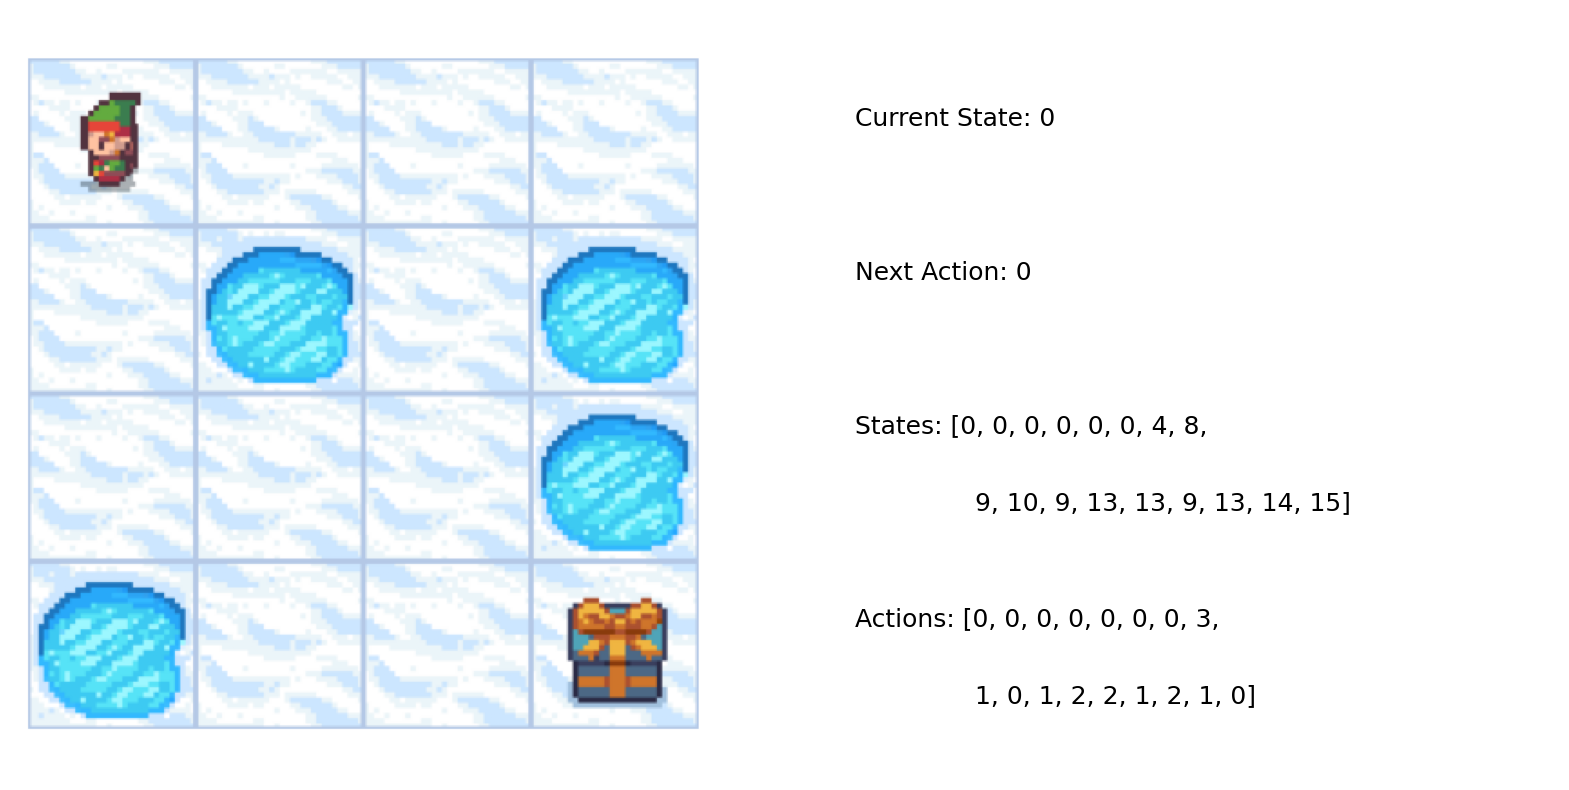

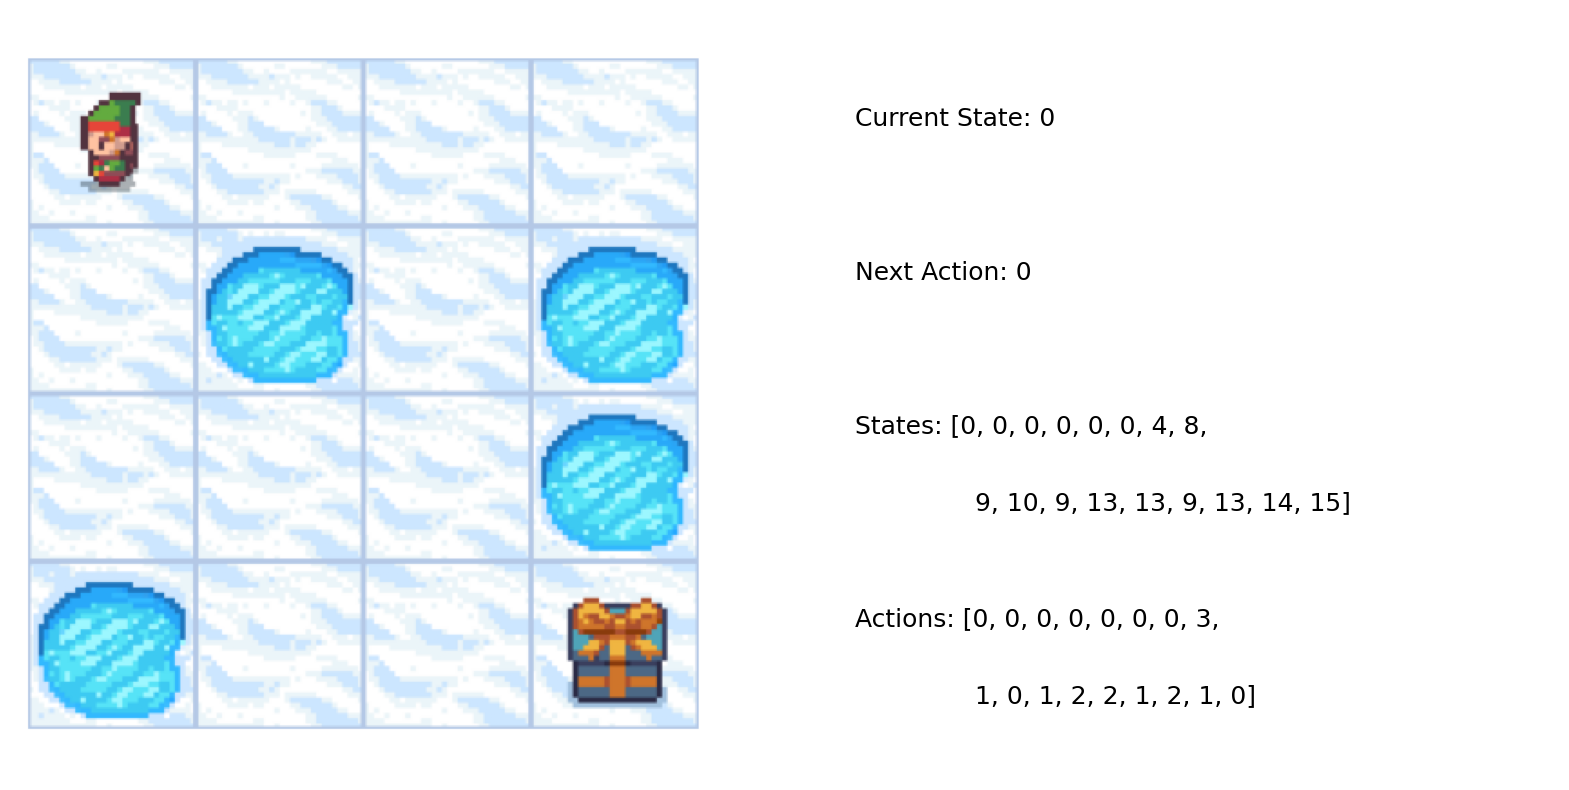

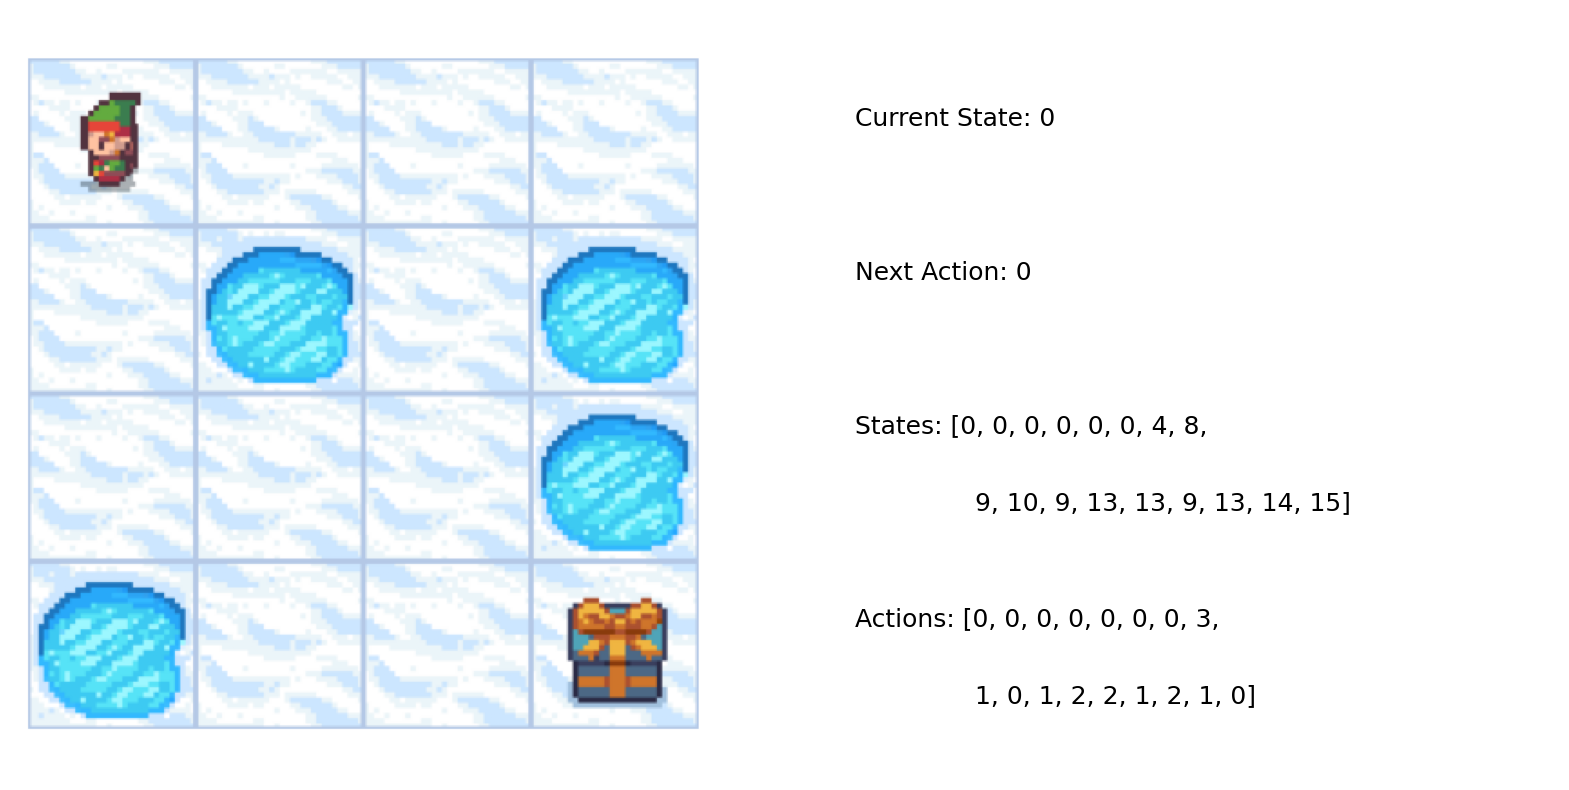

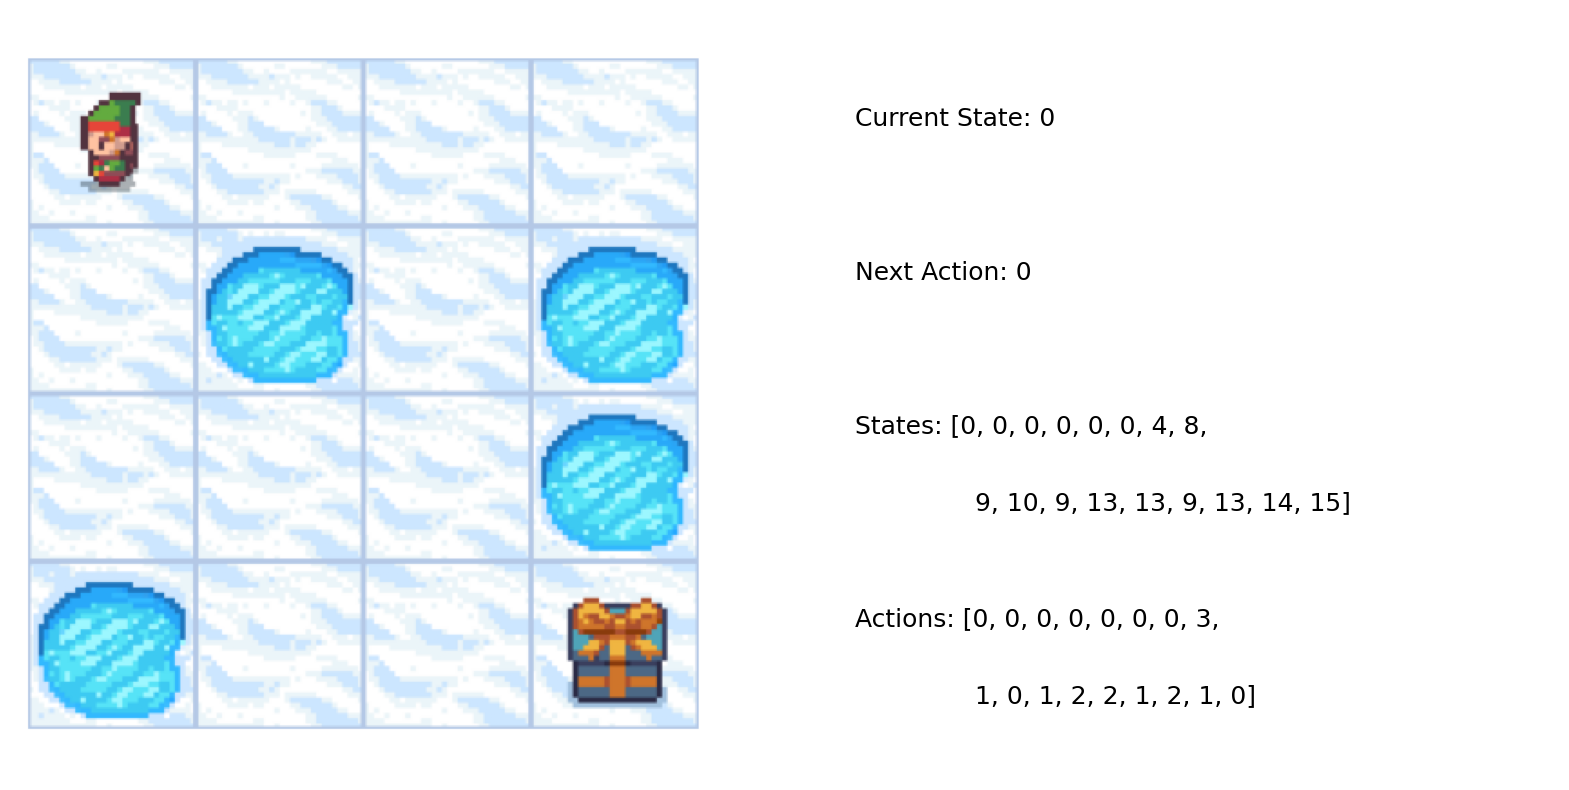

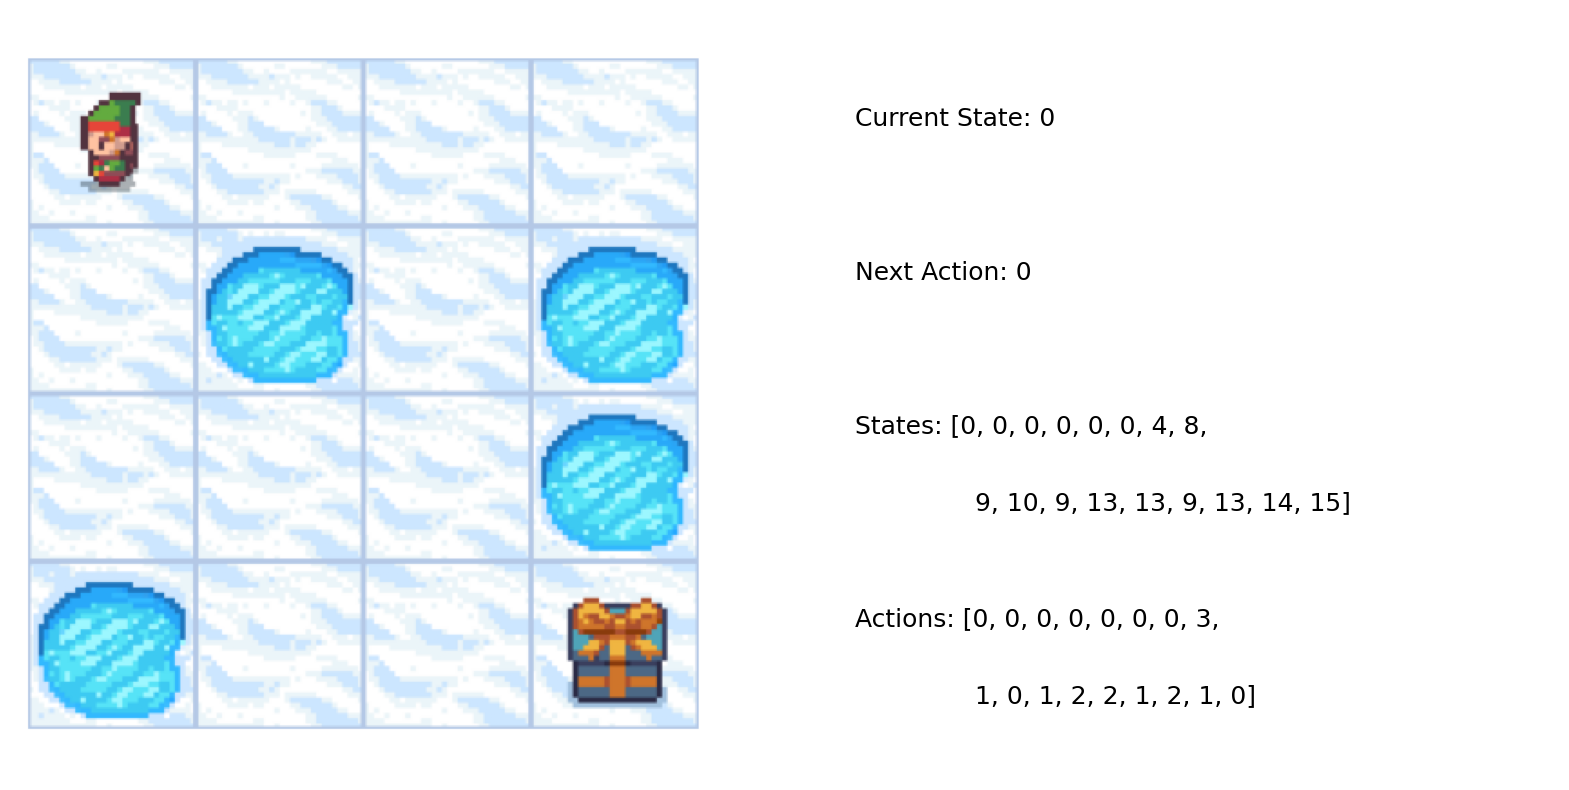

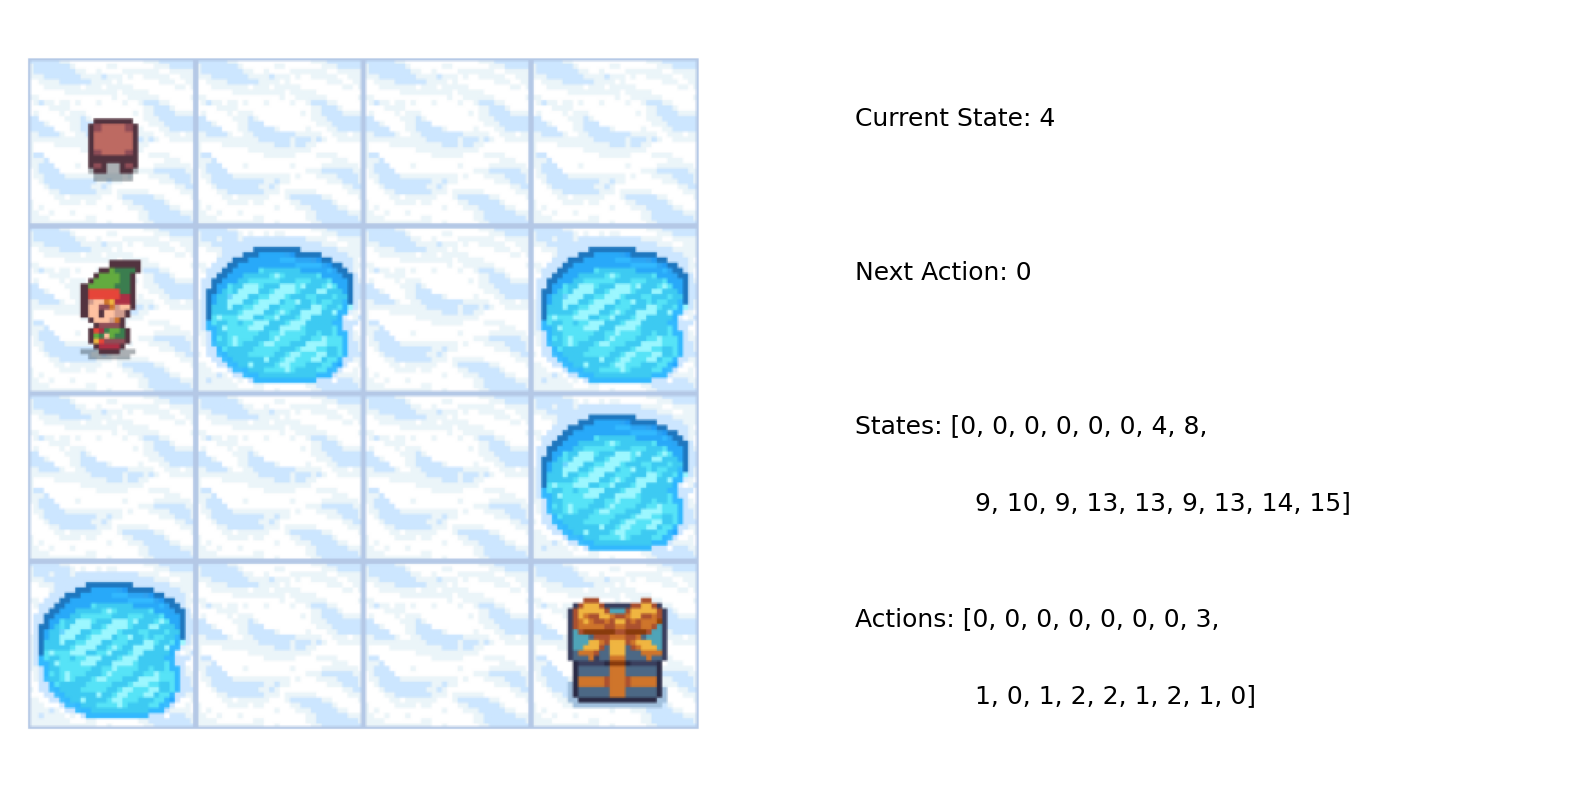

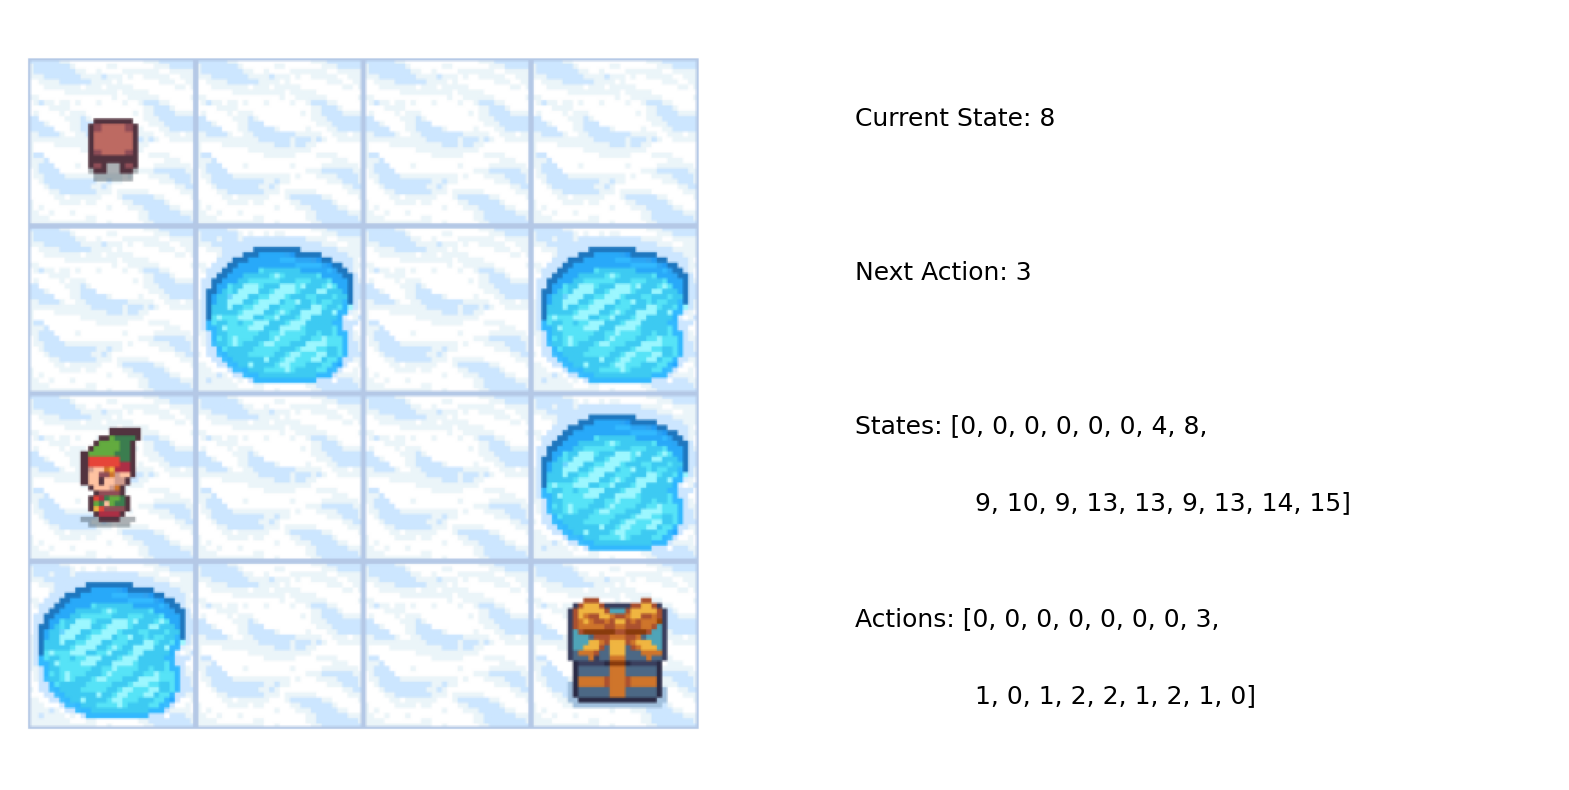

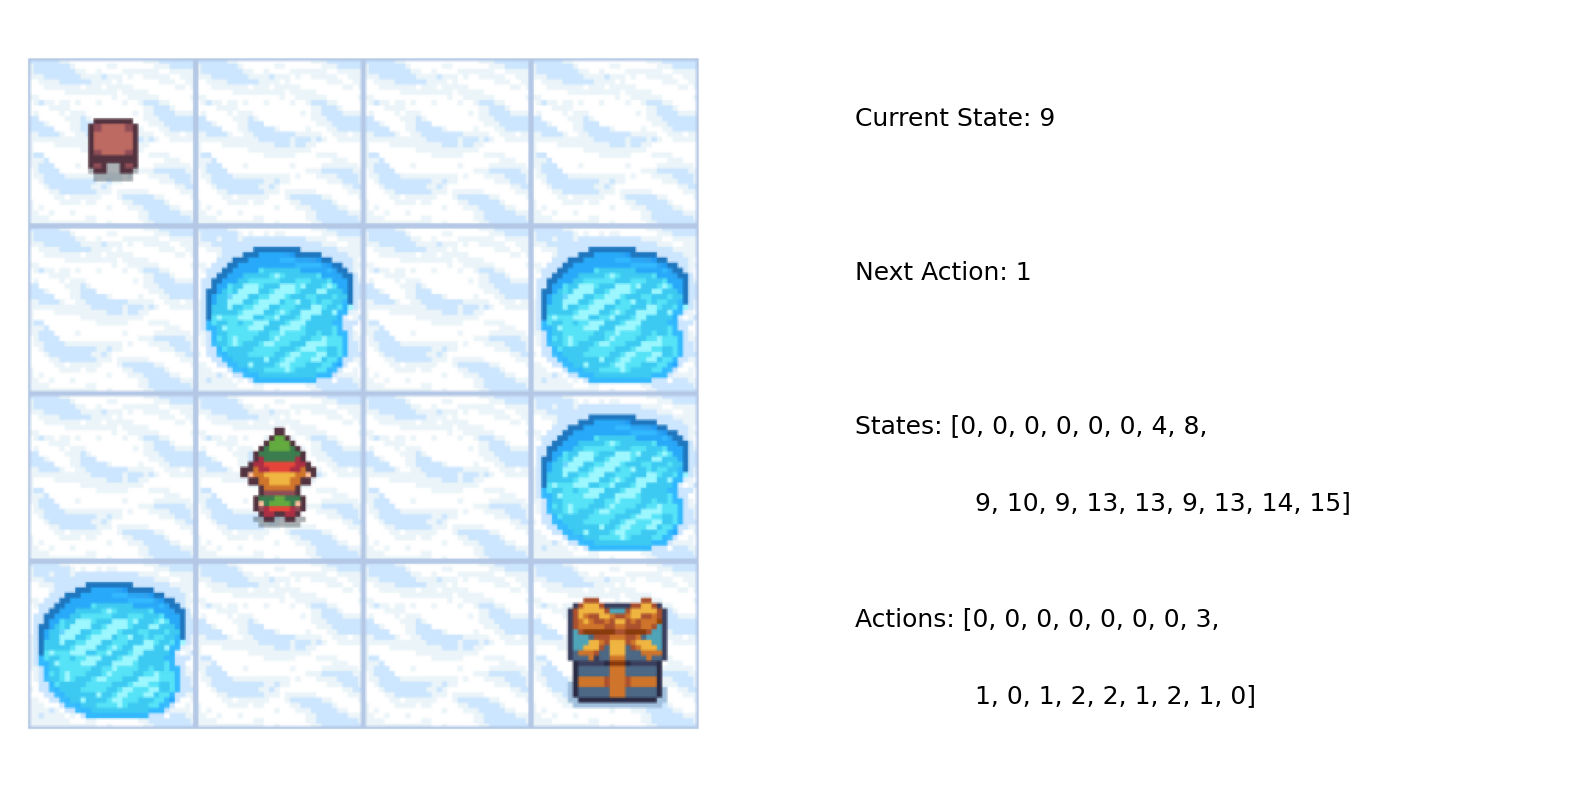

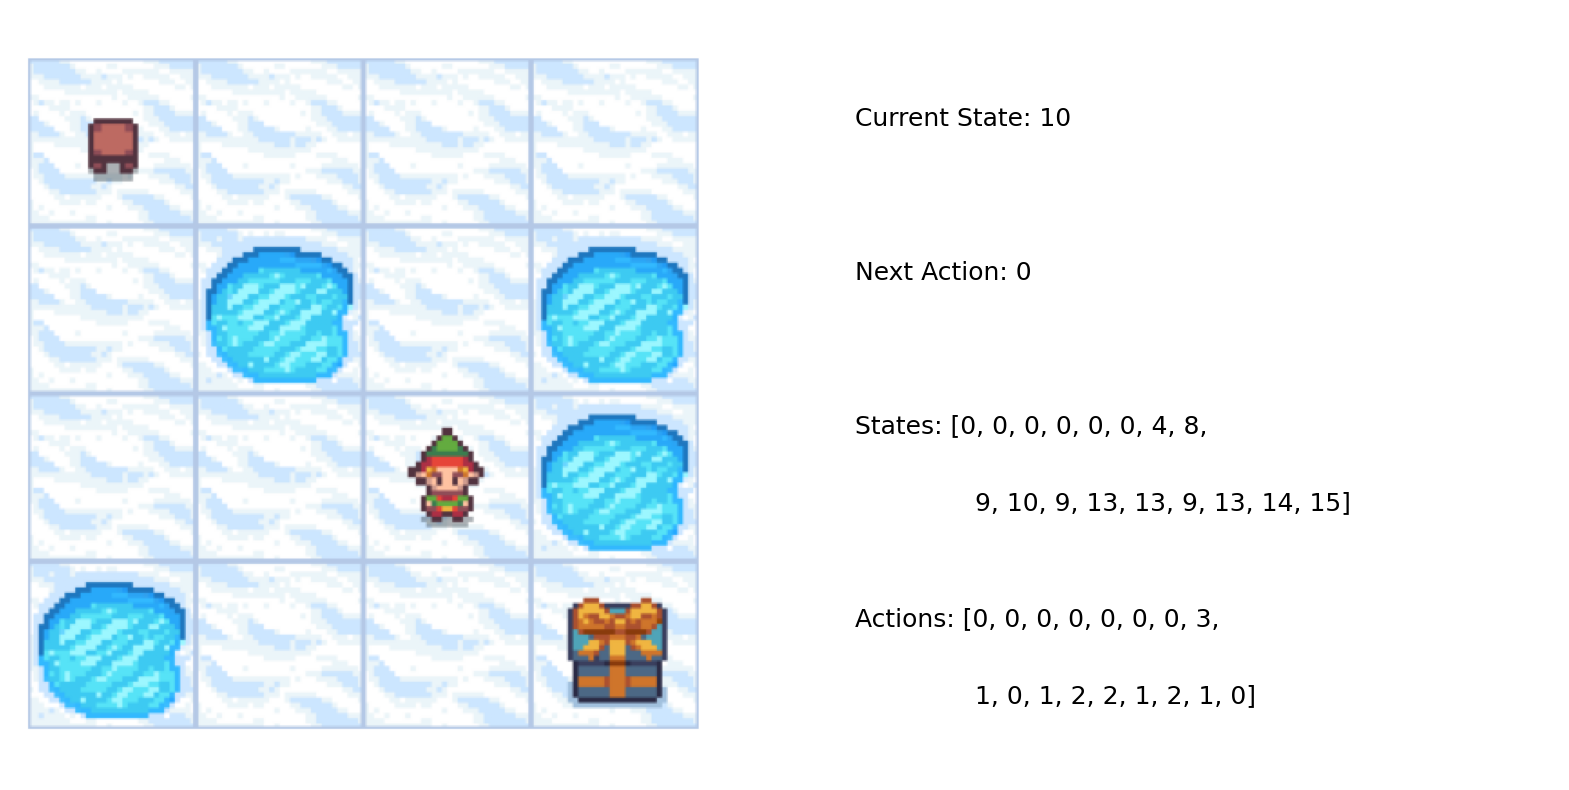

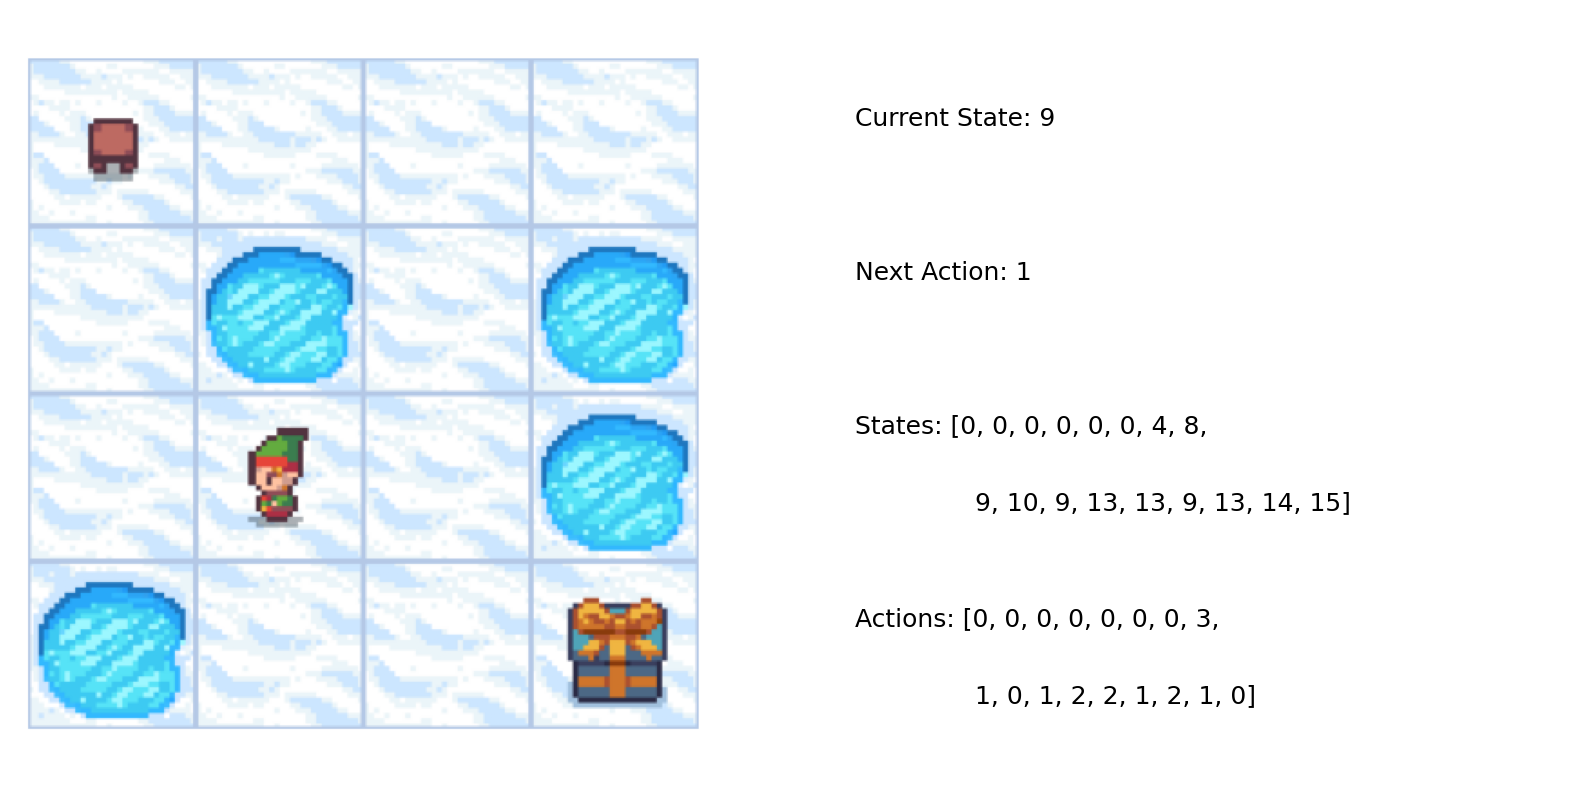

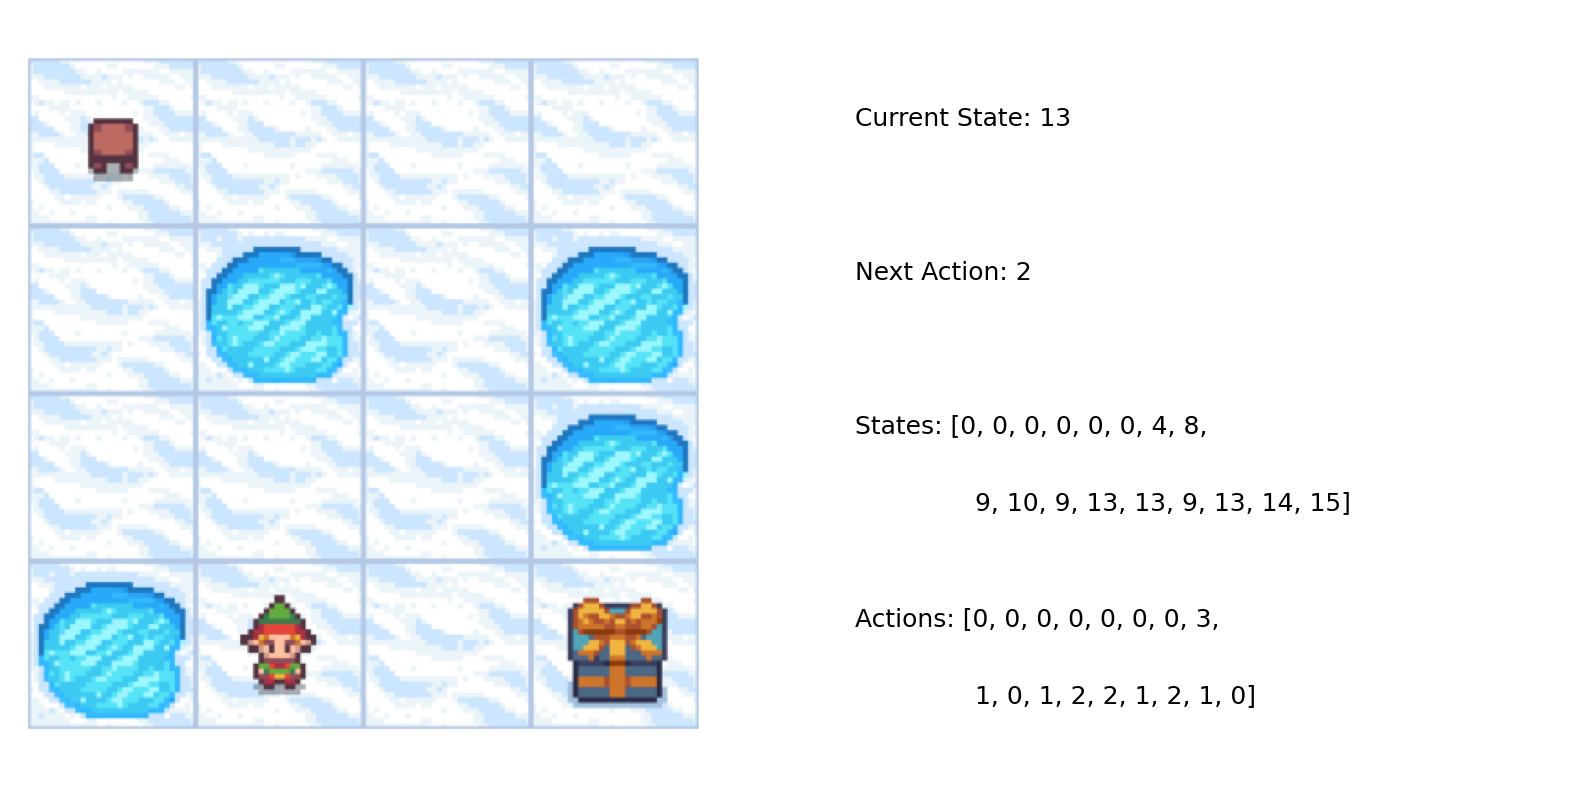

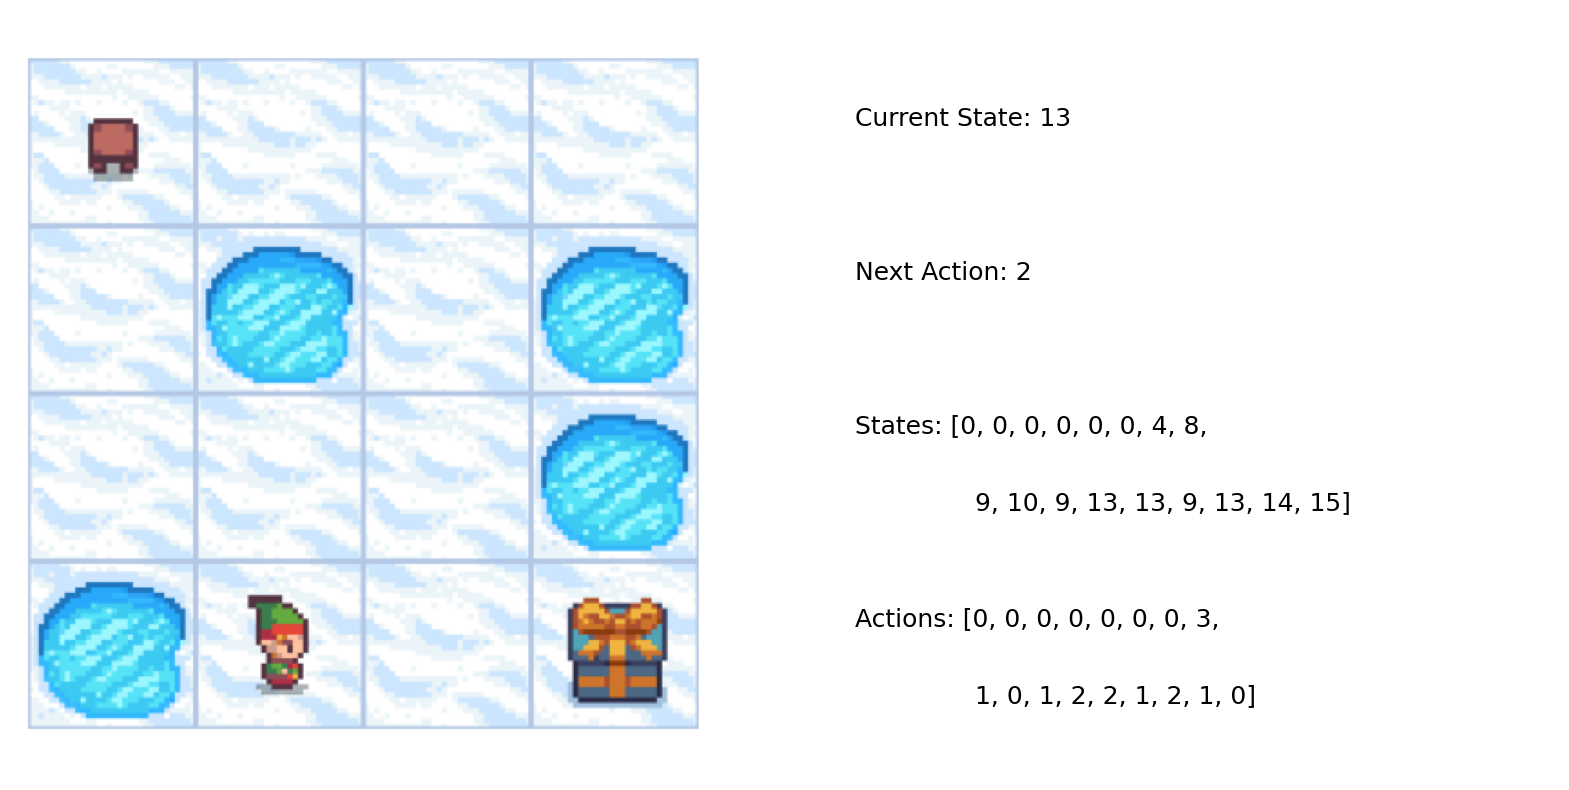

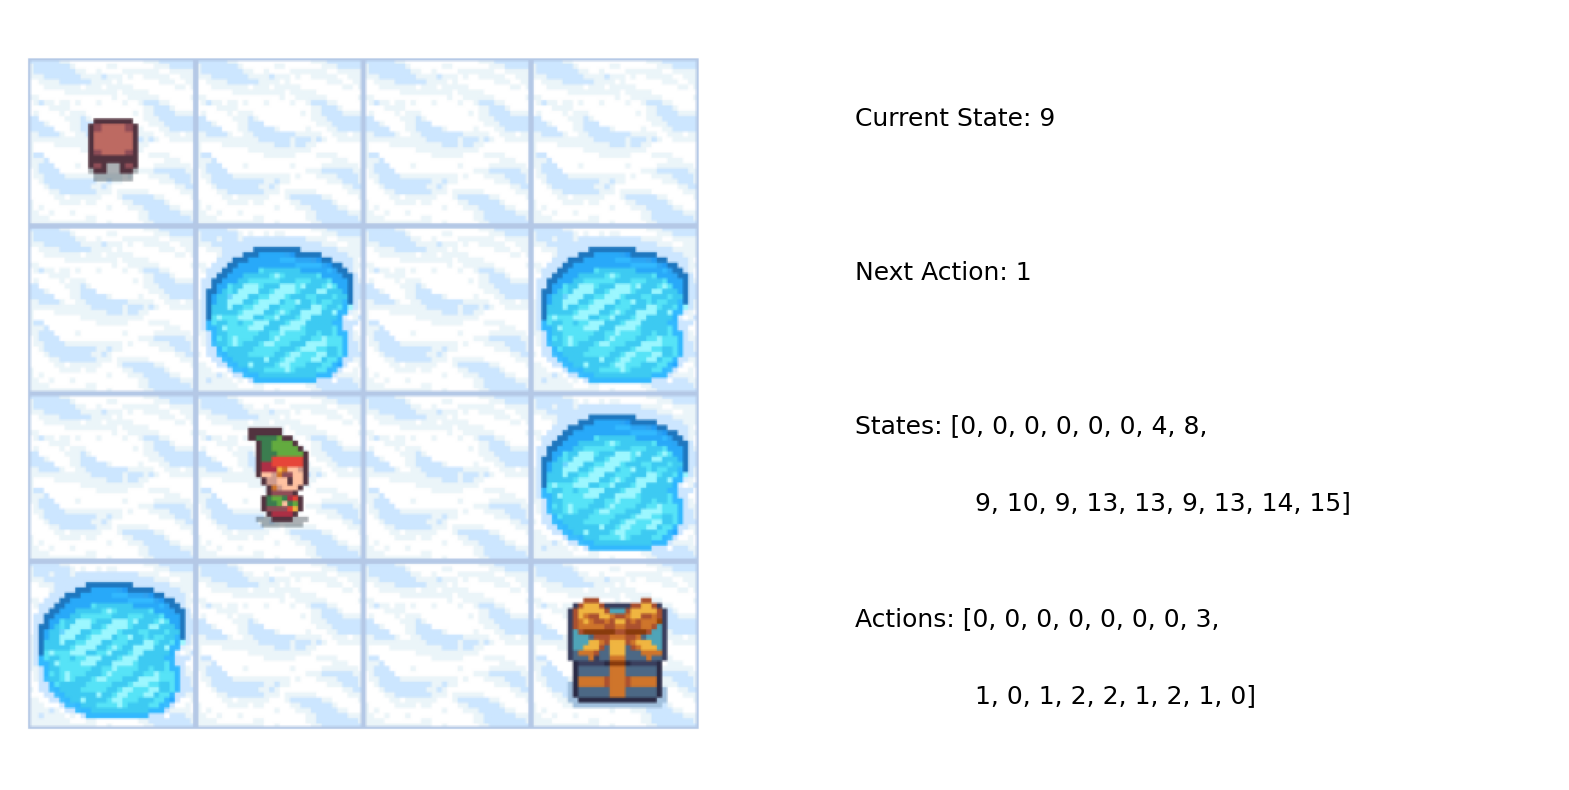

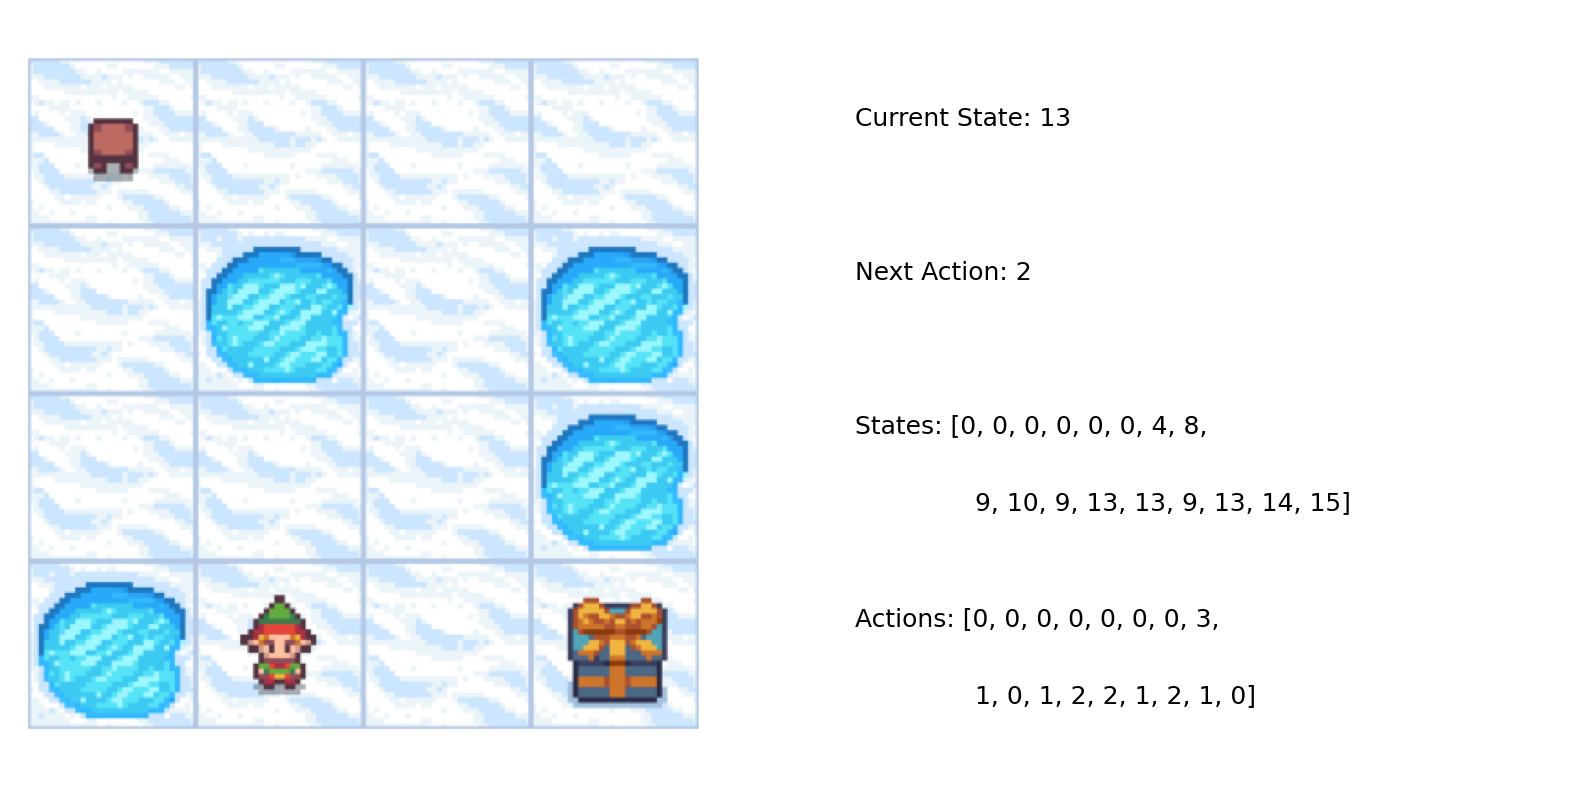

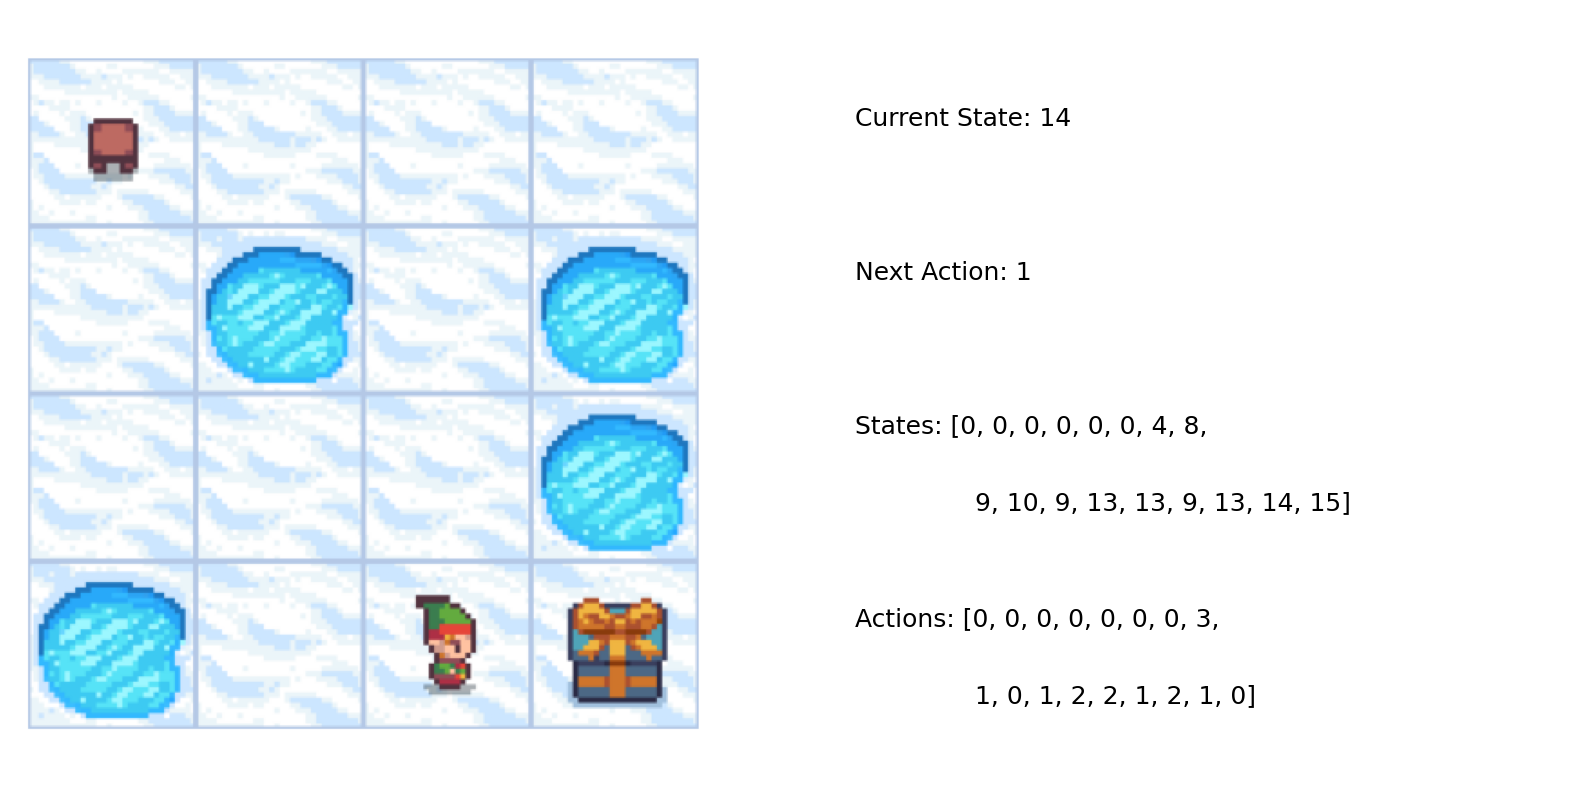

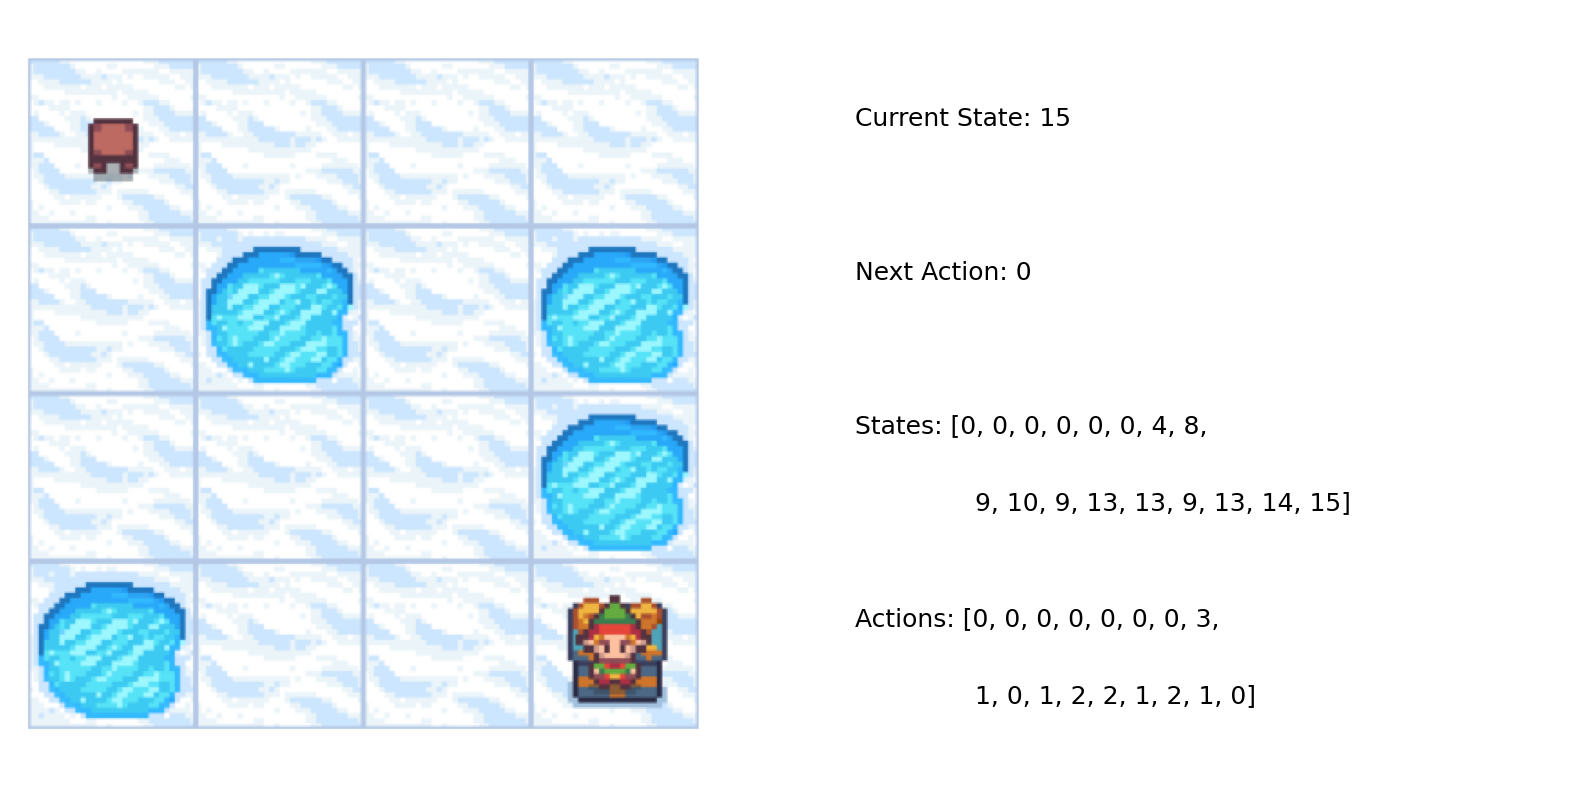

In [95]:
for idx, (state, action) in enumerate(zip(all_states, all_actions)):

    fig = plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    img = mpimg.imread(f'demo_images/image{idx}.png')
    plt.imshow(img)
    plt.axis('off')


    plt.subplot(1, 2, 2)

    states_text_1 = "States: " + str(all_states[:len(all_states)//2])[:-1] + ","
    states_text_2 = " "*15 + str(all_states[len(all_states)//2:])[1:]

    actions_text_1 = "Actions: " + str(all_actions[:len(all_actions)//2])[:-1] + ","
    actions_text_2 = " "*15 + str(all_actions[len(all_actions)//2:])[1:]

    cur_state_text = "Current State: " + str(state)
    next_action_text = "Next Action: " + str(action)

    plt.text(0, 0.85, cur_state_text)
    plt.text(0, 0.65, next_action_text)
    plt.text(0, 0.45, states_text_1)
    plt.text(0, 0.35, states_text_2)
    plt.text(0, 0.2, actions_text_1)
    plt.text(0, 0.1, actions_text_2)
    plt.axis('off')

    #plt.savefig(f'demo_images/ppt_image{idx}.png');
